In [4]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)

import os, sys; 
column_path = os.path.dirname(os.path.realpath('C:/Users/sgopalakrish/Downloads/intellizenz-model-training/Neuro-symbolic-AI/column.py'))
if sys.path.__contains__(column_path)==False:
    sys.path.append(column_path)

import column

from matplotlib import pyplot as plt
%matplotlib inline

## Load data and split

In [5]:
target = "veranst_segment"
feature_columns = column.features_v5  #143 features

data_path = column.data_path_2016_2020_v3
df = pd.read_parquet(data_path)
df = df[feature_columns]

df = df.loc[:,~df.columns.isin(['vg_inkasso', 'tarif_bez'])] #141 features
df = df.fillna(-1) # Fill the Empty NaN values in all the cells with -1

In [6]:
n_total = len(df)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

#Train set = 53%, test set = 20%, valid set = 26%
train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0) #valid split = 33%(0.2/0.6)

In [19]:
unused_feat = []
features = [ col for col in df.columns if col not in unused_feat+[target]] 

## Network parameters

In [20]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

c:\Users\sgopalakrish\Downloads\intellizenz-model-training\Neuro-symbolic-AI\SLASH\TabNet\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


## Training

In [21]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = df[features].values[train_indices][:1000,:]
    y_train = df[target].values[train_indices][:1000]
else:
    X_train = df[features].values[train_indices]
    y_train = df[target].values[train_indices]

X_valid = df[features].values[valid_indices]
y_valid = df[target].values[valid_indices]

X_test = df[features].values[test_indices]
y_test = df[target].values[test_indices]

In [22]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [23]:
from pytorch_tabnet.augmentations import ClassificationSMOTE

aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    augmentations=aug
)

epoch 0  | loss: 1.08151 | train_accuracy: 0.49013 | valid_accuracy: 0.49245 |  0:00:53s
epoch 1  | loss: 0.93927 | train_accuracy: 0.48786 | valid_accuracy: 0.49006 |  0:01:58s
epoch 2  | loss: 0.91963 | train_accuracy: 0.51716 | valid_accuracy: 0.51636 |  0:08:26s
epoch 3  | loss: 0.90065 | train_accuracy: 0.52672 | valid_accuracy: 0.52669 |  0:09:07s
epoch 4  | loss: 0.8925  | train_accuracy: 0.54819 | valid_accuracy: 0.54788 |  0:09:55s
epoch 5  | loss: 0.88646 | train_accuracy: 0.55577 | valid_accuracy: 0.5565  |  0:11:05s
epoch 6  | loss: 0.87949 | train_accuracy: 0.5633  | valid_accuracy: 0.56391 |  0:11:49s
epoch 7  | loss: 0.87545 | train_accuracy: 0.57406 | valid_accuracy: 0.57408 |  0:12:32s
epoch 8  | loss: 0.87182 | train_accuracy: 0.57964 | valid_accuracy: 0.58001 |  0:13:17s
epoch 9  | loss: 0.87227 | train_accuracy: 0.57462 | valid_accuracy: 0.57517 |  0:14:02s
epoch 10 | loss: 0.87107 | train_accuracy: 0.5823  | valid_accuracy: 0.58296 |  0:14:45s
epoch 11 | loss: 0.86

c:\Users\sgopalakrish\Downloads\intellizenz-model-training\Neuro-symbolic-AI\SLASH\TabNet\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


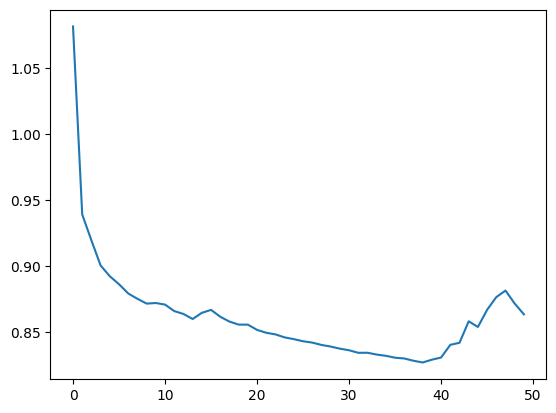

In [24]:
# plot losses
plt.plot(clf.history['loss'])

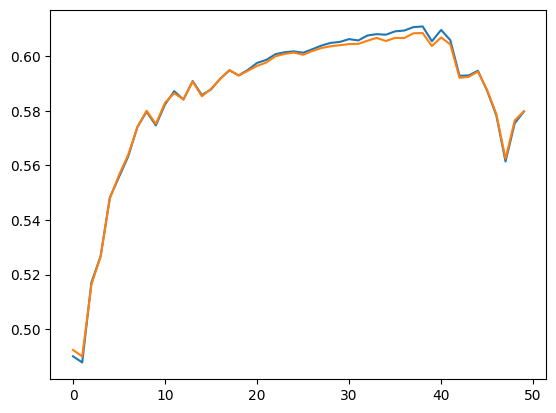

In [25]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

### Predictions

In [26]:
dataset_name = 'Intellizenz'

In [27]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR Intellizenz : 0.6084191086257442
FINAL TEST SCORE FOR Intellizenz : 0.6082395821375273


In [28]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR Intellizenz : 0.6082395821375273


## Save and load Model

In [34]:
# save state dict
saving_path_name = "./baseline_tabnet_model_test_1"
saved_filename = clf.save_model(saving_path_name)

Successfully saved model at ./baseline_tabnet_model_test_1.zip


In [35]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

c:\Users\sgopalakrish\Downloads\intellizenz-model-training\Neuro-symbolic-AI\SLASH\TabNet\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [36]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR Intellizenz : 0.6082395821375273


In [38]:
import wandb

wandb.init(project="Intellizenz", entity="elsaravana")
wandb.config = {
    "learning_rate": 0.02,
    "epochs": 50,
    "batch_size": 16384
}

wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                    preds=loaded_y_pred, y_true=y_test,
                    class_names=[0, 1, 2])})
wandb.log({"pr" : wandb.plot.pr_curve(y_true=y_test, y_probas=loaded_preds,
             labels=['Segment 0-50€', 'Segment 50-100€', 'Segment >100€'], classes_to_plot=[0, 1, 2])})
wandb.log({"roc" : wandb.plot.roc_curve(y_true=y_test, y_probas=loaded_preds,
                labels=['Segment 0-50€', 'Segment 50-100€', 'Segment >100€'], classes_to_plot=[0, 1, 2])})

train_loss = clf.history['loss']
train_accuracy = clf.history['train_accuracy']
validation_accuracy = clf.history['valid_accuracy']
for i,loss in enumerate(train_loss):
    wandb.log({"train_loss": loss, 
        "train_accuracy": train_accuracy[i],
        "validation_accuracy": validation_accuracy[i]})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: elsaravana. Use `wandb login --relogin` to force relogin


wandb: WARNING wandb uses only 10000 data points to create the plots.


In [37]:
assert(test_acc == loaded_test_acc)

In [60]:
# exit_code 0, to finish a successful run
wandb.finish(0)

test_accuracy,▁
train_accuracy,▁▁▃▃▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█████████████▇▇▇▆▅▆
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
validation_accuracy,▁▁▃▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████▇▇▇▆▅▆
test_accuracy,0.60824
train_accuracy,0.57972
train_loss,0.86371
validation_accuracy,0.57981


## Global explainability: feature importance summing to 1

In [29]:
clf.feature_importances_

array([6.09143881e-06, 2.90801378e-04, 1.29410707e-08, 2.56261435e-04,
       2.94613363e-03, 1.87062980e-04, 2.69692726e-03, 7.38474554e-04,
       3.92920564e-04, 1.21372292e-03, 0.00000000e+00, 3.91393566e-02,
       4.97668376e-05, 1.12618881e-06, 9.13612217e-04, 6.84925761e-04,
       1.41449303e-03, 3.66908097e-05, 2.43815747e-03, 1.31114672e-03,
       8.25719374e-04, 4.04154153e-03, 8.65563150e-08, 1.05823872e-03,
       7.98051556e-04, 1.01869987e-02, 6.51549500e-04, 4.55468941e-03,
       2.11926939e-07, 1.06716976e-03, 4.86455782e-05, 4.29325933e-02,
       1.33752015e-01, 7.42527945e-03, 1.62068173e-01, 4.14176062e-03,
       1.93547156e-05, 2.06699324e-02, 6.21938642e-08, 5.38349156e-06,
       1.95887519e-03, 1.25750885e-02, 5.50957617e-03, 1.79402971e-05,
       2.04800059e-02, 1.33321367e-05, 3.45893008e-03, 3.95814731e-05,
       5.23198492e-03, 4.86357135e-07, 0.00000000e+00, 2.13115329e-07,
       2.82069567e-03, 3.06517097e-04, 7.61952664e-03, 4.22531128e-04,
      

## Local explainability and masks

In [30]:
explain_matrix, masks = clf.explain(X_test)

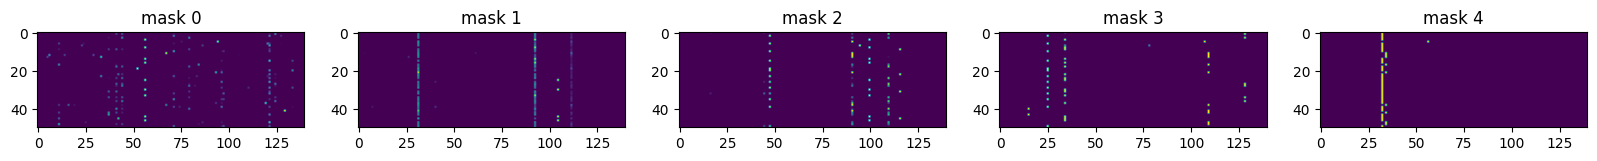

In [31]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")